In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp

事先将train.data文件改写成txt导入至excel文件中后读入。

In [2]:
data0 = pd.read_excel('train.xlsx')
data0

,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8,Column9,Column10,...,Column32,Column33,Column34,Column35,Column36,Column37,Column38,Column39,Column40,Column41
0,2,-56,-0.33,-0.09,0.90,0.2,-11,12,0.004,-0.1,...,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.9,0.032,-0.0009
1,470,-39,0.02,0.12,0.39,-0.6,-12,8,0.009,-1.6,...,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.9,0.034,-0.0011
2,165,4,0.14,0.14,0.78,0.4,-11,-9,-0.003,-0.2,...,0.0,0.000,0.0,0.0,0.0,0.000,0.0,1.0,0.034,-0.0012
3,-113,5,-0.12,0.11,1.06,0.6,-10,-7,-0.008,0.0,...,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.9,0.033,-0.0011
4,-411,-21,-0.17,0.07,1.33,-0.6,-11,0,0.002,0.1,...,0.0,0.000,0.0,0.0,0.0,-0.002,0.0,0.9,0.032,-0.0008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7149,-445,-9,0.20,-0.02,0.88,-0.2,-8,7,-0.002,-0.8,...,0.0,0.000,0.0,0.0,0.0,0.001,0.0,0.5,0.017,-0.0006
7150,9,20,-0.04,-0.03,0.47,-0.6,-9,6,0.002,0.0,...,0.0,0.001,0.0,0.0,0.0,0.000,0.0,0.5,0.017,-0.0005
7151,50,23,0.14,0.02,0.45,-0.5,-8,1,0.005,-0.1,...,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.5,0.017,-0.0006
7152,53,23,0.17,0.02,0.45,-0.4,-8,1,0.005,-0.1,...,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.5,0.017,-0.0007


“在 train.data 文件中，有 7154 条 41 维的数据，其中前 40 列为 feature，最后一列为 label.”

In [3]:
data = data0.copy(deep=True).dropna()
names = data.columns

In [8]:
def split_train_test(data, test_ratio):
    np.random.seed(46)
    shuffled_indices = np.random.permutation(len(data))  # 生成和原数据等长的无序索引
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train,test = split_train_test(data, 0.1)
train,test = train.to_numpy(),test.to_numpy()

In [13]:
X_train,X_test = train[:,0:-1],test[:,0:-1]
Y_train,Y_test = train[:,-1],test[:,-1]

In [18]:
X_train.shape

(6439, 40)

## 回归树

In [41]:
# 定义一个结点的数据结构
class Node(object):

    def __init__(self, x=None):
        self.label = None
        self.x = x
        self.s = None  # Number
        self.child = []
        self.y = None
        self.data = None

    def append(self, child):
        self.child.append(child)

    def predict_regression(self, features):
        if self.y is not None:
            return self.y
        child_idx = 0 if features[self.label] <= self.s else 1
        return self.child[child_idx].predict_regression(features)

In [112]:
class RegressionTree(object):

    def __init__(self, max_depth=1):
        self.tree = Node()
        self.max_depth = max_depth
        self.loss = []

    def fit(self, X_train, Y_train):
        A_recorder = np.arange(X_train.shape[1])
        self._train(X_train, Y_train, self.tree, A_recorder)
        
        # # 绘制loss曲线
        # plt.plot(self.loss,label = "Loss Curve")
        # plt.legend()
        # plt.savefig("loss.pdf")
        # plt.show()
                

    def predict(self, X):
        n = X.shape[0]
        Y = np.zeros(n)
        for i in range(n):
            Y[i] = self.tree.predict_regression(X[i, :])
        return Y

    def _train(self, A, D, node, AR, depth=0):
        # 1. 结束条件：到最后一层 | A 或 D 一样
        if depth == self.max_depth or np.all(D == D[0]) or np.all(A == A[0]):
            node.y = np.mean(D)
            return 
        # 2. 选择第j个变量A_j（切分变量splitting variable）和 切分点s（splitting point）
        min_f, min_j, min_s, min_idx1, min_idx2 = None, None, None, None, None
        row, col = A.shape
        
        for j in range(col):
            a_col = A[:, j]
            # 这里s 就直接取最值的平均数
            s = (np.max(a_col) + np.min(a_col)) * 0.5
            R1_idx, R2_idx = np.argwhere(a_col <= s).T[0], np.argwhere(a_col > s).T[0]
            if R1_idx.size == 0 or R2_idx.size == 0:
                continue
            # 选择切分变量和切分点
            c1, c2 = np.mean(D[R1_idx]), np.mean(D[R2_idx])
            f1, f2 = np.sum(np.square(D[R1_idx] - c1)), np.sum(np.square(D[R2_idx] - c2))
            
            loss = (f1+f2)
            self.loss.append(loss)
            # if len(self.loss)>2 and np.abs(self.loss[-1]-self.loss[-2])<1e-7:
            #     return
            
            if min_f is None or min_f > f1 + f2:
                min_f, min_j, min_s, min_idx1, min_idx2 = f1 + f2, j, s, R1_idx, R2_idx
        if min_f is None:
            node.y = np.mean(D)
            return 
        # 3. 向下一层展开
        node.label, node.s = AR[min_j], min_s
        for i, idx_list in enumerate((min_idx1, min_idx2)):
            child = Node(i)
            node.append(child)
            self._train(A[idx_list, :], D[idx_list], child, AR, depth+1)
            

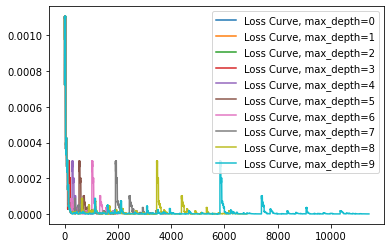

In [113]:
for i in range(10):   
    tree = RegressionTree(max_depth=i)
    tree.fit(X_train,Y_train)
    plt.plot(tree.loss,label = "Loss Curve, max_depth="+str(i))
plt.legend()
plt.savefig("loss.pdf")
plt.show()
                


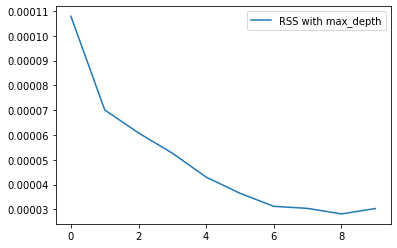

In [69]:
RSS = []
for i in range(10):   
    tree = RegressionTree(max_depth=i)
    tree.fit(X_train,Y_train)
    Y_hat = tree.predict(X_test)
    RSS.append(np.sum(np.square(Y_test-Y_hat)))
plt.plot(RSS,label = "RSS with max_depth")
plt.legend()
plt.savefig("rss.pdf")
plt.show()

In [56]:
# # 检测一下白噪声
# from statsmodels.stats.diagnostic import acorr_ljungbox as LB
# err_df = pd.DataFrame(Y_test-Y_hat)
# LB(err_df,return_df =bool)

## XGBoost

In [94]:
class XGBoost(object):

    def __init__(self, max_iter=10, sample_rate=0.5, learn_rate=0.1, max_depth=3):
        self.max_iter = max_iter
        self.sample_rate = sample_rate  # 0 < sample_rate <= 1
        self.learn_rate = learn_rate
        self.max_depth = max_depth
        self.dtrees = dict()
        self.original_f = None
        self.loss = []

    def fit(self, X_train, Y_train):
        n, m = X_train.shape
        # 记录每个样本对应的预测值，这个偏移值需要加到XGBoost的预测结果中
        f = np.ones(n) * np.mean(Y_train)
        self.original_f = np.array(f)
        # 数据集随机抽样，减少模型方差
        n_sample = int(n*self.sample_rate)

        for iter_ in range(self.max_iter):
            sample_idx = np.random.permutation(n)[:n_sample]
            X_train_subset, Y_train_subset = X_train[sample_idx, :], Y_train[sample_idx]
            y_predict_subset = np.zeros(n_sample)
            # 用损失函数的负梯度作为回归树的残差近似值
            for j in range(n_sample):
                k = sample_idx[j]
                y_predict_subset[j] = f[k]
            residual = Y_train_subset - y_predict_subset
            loss = np.sum(np.square(residual))
            self.loss.append(loss)

            # 用残差作为新标签训练一颗新树
            dtree = RegressionTree(max_depth=self.max_depth)    # 用到之前的回归树
            dtree.fit(X_train_subset, residual)
            self.dtrees[iter_] = dtree
            # 更新样本预测值
            for j in range(n):
                f[j] += self.learn_rate * dtree.predict(np.array([X_train[j]]))

    def predict(self, X):
        n = X.shape[0]
        Y = np.zeros([n, self.max_iter])
        for iter_ in range(self.max_iter):
            dtree = self.dtrees[iter_]
            Y[:, iter_] = dtree.predict(X)
        # 将XGBoost初始化时的偏移值需要加到预测结果中
        row,col = X.shape
        f = self.original_f[:row]
        return np.sum(Y, axis=1) + f

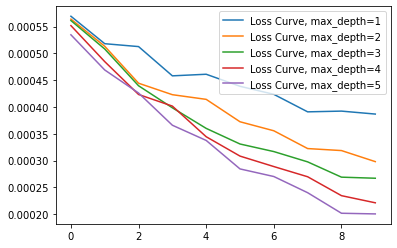

In [96]:
for i in range(1,6):   
    boosting_tree = XGBoost(max_depth=i)
    boosting_tree.fit(X_train,Y_train)
    plt.plot(boosting_tree.loss,label = "Loss Curve, max_depth="+str(i))

# boosting_tree.loss
plt.legend()
plt.savefig("boosting_treeloss.pdf")
plt.show()

In [102]:
RSS = []
for i in range(1,15):   
    boosting_tree = XGBoost(max_depth=i)
    boosting_tree.fit(X_train,Y_train)
    Y_hat = boosting_tree.predict(X_test)
    RSS.append(np.sum(np.square(Y_test-Y_hat)))


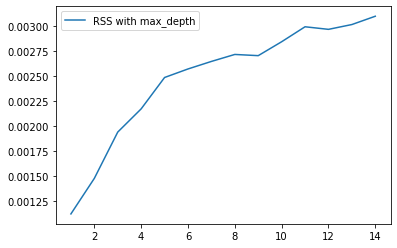

In [103]:
axe = [i for i in range(1,15)]
plt.plot(axe,RSS,label = "RSS with max_depth")
plt.legend()
plt.savefig("boosting_treerss.pdf")
plt.show()